# Label-Aware DDC for Classification Problems

This notebook demonstrates **label-aware DDC** for supervised learning problems. We'll show how `fit_ddc_coreset_by_label` preserves class proportions while maintaining distributional fidelity.

## What You'll Learn

- When to use label-aware DDC (supervised problems)
- Preserving class proportions matters for classification
- Impact on downstream model performance

## The Dataset

We'll use a **binary classification dataset** (Adult Census Income or synthetic) to demonstrate label-aware DDC's advantage over global DDC.

## 1. Setup

In [1]:
# Install dd-coresets
# For Google Colab: uncomment the line below
# !pip install dd-coresets

# For Kaggle: usually already available or use:
# !pip install dd-coresets --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, accuracy_score
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

from scipy.stats import wasserstein_distance, ks_2samp

from dd_coresets import fit_ddc_coreset

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Imports successful")

Imports successful


## 2. Data Loading

We'll use the **Adult Census Income** dataset, a well-known binary classification dataset from the UCI Machine Learning Repository. This dataset contains demographic and employment information, with the goal of predicting whether income exceeds $50K/year.

The dataset is publicly available and can be downloaded via `sklearn.datasets.fetch_openml`.

In [3]:
# Load Adult Census Income dataset from OpenML
print("Loading Adult Census Income dataset from OpenML...")
try:
    # Try to load from cache first (faster)
    adult = fetch_openml("adult", version=2, as_frame=True, parser="pandas")
    print(f"Dataset loaded: {adult.frame.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("This may take a few minutes on first download...")
    adult = fetch_openml("adult", version=2, as_frame=True, parser="pandas")

# Extract features and target
df = adult.frame.copy()

# The target column is 'class' with values '<=50K' and '>50K'
# Convert to binary: 0 for '<=50K', 1 for '>50K'
if 'class' in df.columns:
    df['target'] = (df['class'] == '>50K').astype(int)
    df = df.drop(columns=['class'])

print(f"\nDataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df["target"].value_counts(normalize=True))
print(f"\nFirst few rows:")
df.head()

Loading Adult Census Income dataset from OpenML...
Dataset loaded: (48842, 15)

Dataset shape: (48842, 15)

Label distribution:
target
0    0.760718
1    0.239282
Name: proportion, dtype: float64

First few rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0


## 3. Preprocessing

We'll select numeric features, handle missing values, and scale the data. DDC requires **preprocessed numerical features**.

In [4]:
# Select numeric features (exclude target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'target']

print(f"Selected {len(numeric_cols)} numeric features")
print(f"Features: {numeric_cols}")

# Extract features and target
X_raw = df[numeric_cols].copy()
y_raw = df['target'].values

# Handle missing values (simple mean imputation)
if X_raw.isnull().sum().sum() > 0:
    print(f"\nFound missing values. Imputing with mean...")
    X_raw = X_raw.fillna(X_raw.mean())
else:
    print("\nNo missing values")

# Convert to NumPy array
X_raw = X_raw.values

print(f"\nFeature matrix shape: {X_raw.shape}")
print(f"Target vector shape: {y_raw.shape}")

Selected 6 numeric features
Features: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

No missing values

Feature matrix shape: (48842, 6)
Target vector shape: (48842,)


In [5]:
# Scale features (important for DDC, which uses Euclidean distances)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split into train/test (stratified to preserve label proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_raw, 
    test_size=0.3, 
    stratify=y_raw, 
    random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining label distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_train)*100:.2f}%)")

Training set: 34,189 samples
Test set: 14,653 samples

Training label distribution:


  Class 0: 26,008 (76.07%)
  Class 1: 8,181 (23.93%)


## 4. Full-Data Baseline Model

We'll train a logistic regression model on the **full training set** to establish a gold standard. This will be our baseline for comparison.

In [6]:
# Train on full training data
lr_full = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight=None  # No class balancing
)

lr_full.fit(X_train, y_train)

# Predict on test set
y_pred_proba_full = lr_full.predict_proba(X_test)[:, 1]
y_pred_full = lr_full.predict(X_test)

# Evaluate
baseline_auc = roc_auc_score(y_test, y_pred_proba_full)
baseline_brier = brier_score_loss(y_test, y_pred_proba_full)
baseline_accuracy = accuracy_score(y_test, y_pred_full)

print("Full-Data Baseline Metrics:")
print(f"  ROC AUC:  {baseline_auc:.4f}")
print(f"  Brier Score: {baseline_brier:.4f}")
print(f"  Accuracy:    {baseline_accuracy:.4f}")

# Store for later comparison
baseline_metrics = {
    'method': 'Full Data',
    'auc': baseline_auc,
    'brier': baseline_brier,
    'accuracy': baseline_accuracy
}

Full-Data Baseline Metrics:
  ROC AUC:  0.8316
  Brier Score: 0.1291
  Accuracy:    0.8181


## 5. Baseline Subsets: Random and Stratified

Before using DDC, let's establish simple baselines:

- **Random subset**: Uniform sampling (may miss rare classes)
- **Stratified subset**: Preserves class proportions (common practice in supervised learning)

We'll use `k_reps = 1000` representatives.

In [7]:
k_reps = 1000  # Number of representatives
print(f"Target coreset size: {k_reps} representatives ({k_reps/len(X_train)*100:.2f}% of training data)")

Target coreset size: 1000 representatives (2.92% of training data)


In [8]:
# Random subset
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(len(X_train), size=k_reps, replace=False)
X_random = X_train[random_indices]
y_random = y_train[random_indices]
w_random = np.ones(k_reps) / k_reps  # Uniform weights

print("Random subset created")
print(f"  Shape: {X_random.shape}")
print(f"  Label distribution: {np.bincount(y_random) / len(y_random)}")

Random subset created
  Shape: (1000, 6)
  Label distribution: [0.736 0.264]


In [9]:
# Stratified subset (preserves class proportions)
from sklearn.model_selection import train_test_split

# Manual stratified sampling to get exactly k_reps
strat_indices = []
for class_label in np.unique(y_train):
    class_mask = (y_train == class_label)
    class_indices = np.where(class_mask)[0]
    n_class = int(k_reps * np.sum(class_mask) / len(y_train))
    selected = np.random.choice(class_indices, size=n_class, replace=False)
    strat_indices.extend(selected)

# If we don't have exactly k_reps, adjust
if len(strat_indices) < k_reps:
    remaining = k_reps - len(strat_indices)
    remaining_indices = np.setdiff1d(np.arange(len(X_train)), strat_indices)
    strat_indices.extend(np.random.choice(remaining_indices, size=remaining, replace=False))
elif len(strat_indices) > k_reps:
    strat_indices = np.random.choice(strat_indices, size=k_reps, replace=False)

X_strat = X_train[strat_indices]
y_strat = y_train[strat_indices]
w_strat = np.ones(len(X_strat)) / len(X_strat)  # Uniform weights

print("Stratified subset created")
print(f"  Shape: {X_strat.shape}")
print(f"  Label distribution: {np.bincount(y_strat) / len(y_strat)}")
print(f"  Original label distribution: {np.bincount(y_train) / len(y_train)}")

Stratified subset created
  Shape: (1000, 6)
  Label distribution: [0.761 0.239]
  Original label distribution: [0.76071251 0.23928749]


## 6. Label-Aware DDC Coreset

To preserve class proportions while still benefiting from DDC's distribution-preserving properties, we apply DDC **separately within each class**. This:

1. Preserves label proportions by design
2. Maintains density–diversity structure **within each class**
3. Still provides weighted representatives that approximate the full distribution

**Key insight**: By applying DDC separately to each class, we ensure that the coreset maintains the original class balance while still capturing the distributional structure within each class.

In [10]:
# Label-aware DDC: apply DDC separately to each class
S_labelaware_list = []
w_labelaware_list = []
y_labelaware_list = []

for class_label in np.unique(y_train):
    # Extract data for this class
    class_mask = (y_train == class_label)
    X_class = X_train[class_mask]
    
    # Compute class proportion
    p_class = np.sum(class_mask) / len(y_train)
    
    # Allocate representatives proportionally
    k_class = max(1, int(round(k_reps * p_class)))
    
    print(f"\nClass {class_label}: {np.sum(class_mask):,} samples ({p_class:.2%})")
    print(f"  Allocating {k_class} representatives...")
    
    # Fit DDC on this class
    # Use larger n0 for better density estimation when class is large enough
    n0_class = min(20_000, len(X_class))
    
    # Optimized parameters (from grid search to minimize joint distribution errors)
    # These parameters were found to minimize covariance and correlation errors
    alpha_opt = 0.2  # Lower alpha favors diversity (better coverage)
    gamma_opt = 1.5  # Higher gamma for smoother weight assignments
    m_neighbors_opt = 16  # Fewer neighbors for faster computation, still adequate
    refine_iters_opt = 2  # More refinement iterations for better quality
    
    # Adjust m_neighbors for very small classes
    m_neighbors_class = max(5, min(m_neighbors_opt, len(X_class) // 10))
    
    S_class, w_class, info_class = fit_ddc_coreset(
        X_class,
        k=k_class,
        n0=n0_class,
        alpha=alpha_opt,
        m_neighbors=m_neighbors_class,
        gamma=gamma_opt,
        refine_iters=refine_iters_opt,
        reweight_full=True,  # Important: reweight on full class data
        random_state=RANDOM_STATE + class_label,  # Different seed per class
    )
    
    # Scale weights by class proportion to preserve global distribution
    w_class_scaled = w_class * p_class
    
    S_labelaware_list.append(S_class)
    w_labelaware_list.append(w_class_scaled)  # Already scaled by proportion
    y_labelaware_list.append(np.full(len(S_class), class_label))

# Concatenate all classes
S_labelaware = np.vstack(S_labelaware_list)
w_labelaware = np.concatenate(w_labelaware_list)
y_labelaware = np.concatenate(y_labelaware_list)

# Renormalize weights (they should already sum close to 1, but ensure it)
w_labelaware = w_labelaware / w_labelaware.sum()

print(f"\nLabel-aware DDC coreset created: {S_labelaware.shape}")
print(f"  Weights sum: {w_labelaware.sum():.6f}")


Class 0: 26,008 samples (76.07%)
  Allocating 761 representatives...


/var/folders/cg/mqv8qvn17hx0typ7nf1q0x2jjykzd2/T/ipykernel_23394/23080767.py:34: DeprecationWarning: Parameter 'm_neighbors' is deprecated. Use 'mode', 'preset', or '*_cfg' dicts instead.
  S_class, w_class, info_class = fit_ddc_coreset(



Class 1: 8,181 samples (23.93%)
  Allocating 239 representatives...


/var/folders/cg/mqv8qvn17hx0typ7nf1q0x2jjykzd2/T/ipykernel_23394/23080767.py:34: DeprecationWarning: Parameter 'm_neighbors' is deprecated. Use 'mode', 'preset', or '*_cfg' dicts instead.
  S_class, w_class, info_class = fit_ddc_coreset(



Label-aware DDC coreset created: (1000, 6)
  Weights sum: 1.000000


In [11]:
# Verify label proportions are preserved
print("Label Distribution Comparison:")
print(f"  Original training set:")
orig_props = np.bincount(y_train) / len(y_train)
for label, prop in enumerate(orig_props):
    print(f"    Class {label}: {prop:.4f}")

print(f"\n  Label-aware DDC coreset:")
labelaware_props = np.bincount(y_labelaware) / len(y_labelaware)
for label, prop in enumerate(labelaware_props):
    print(f"    Class {label}: {prop:.4f}")

print(f"\nClass proportion preservation:")
for label in range(len(orig_props)):
    diff = abs(labelaware_props[label] - orig_props[label])
    print(f"    Class {label}: {diff:.6f} difference")

Label Distribution Comparison:
  Original training set:
    Class 0: 0.7607
    Class 1: 0.2393

  Label-aware DDC coreset:
    Class 0: 0.7610
    Class 1: 0.2390

Class proportion preservation:
    Class 0: 0.000287 difference
    Class 1: 0.000287 difference


## 7. Distribution Comparison

Let's compare how well each subset/coreset preserves the **marginal distributions** of the original training data. We'll use:

- **Wasserstein-1 distance**: Measures how much we need to "move" probability mass to match distributions
- **Kolmogorov-Smirnov statistic**: Measures the maximum difference between cumulative distribution functions

For DDC coresets, we'll use the **weights** to compute weighted distributions.

In [12]:
# Select a few features for comparison (e.g., first 5 or high-variance features)
feature_indices = list(range(min(5, X_train.shape[1])))
feature_names = [f"Feature {i}" for i in feature_indices]

print(f"Comparing distributions for {len(feature_indices)} features:")
print(feature_names)

Comparing distributions for 5 features:
['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']


In [13]:
def compute_wasserstein_weighted(source_data, target_data, source_weights=None, target_weights=None):
    """Compute Wasserstein-1 distance between weighted distributions."""
    if source_weights is None:
        source_weights = np.ones(len(source_data)) / len(source_data)
    if target_weights is None:
        target_weights = np.ones(len(target_data)) / len(target_data)
    
    # Sort by value for computing Wasserstein distance
    source_sorted_idx = np.argsort(source_data)
    target_sorted_idx = np.argsort(target_data)
    
    source_sorted = source_data[source_sorted_idx]
    target_sorted = target_data[target_sorted_idx]
    
    source_weights_sorted = source_weights[source_sorted_idx]
    target_weights_sorted = target_weights[target_sorted_idx]
    
    # Compute cumulative distributions
    source_cdf = np.cumsum(source_weights_sorted)
    target_cdf = np.cumsum(target_weights_sorted)
    
    # Interpolate to common grid
    all_values = np.unique(np.concatenate([source_sorted, target_sorted]))
    all_values = np.sort(all_values)
    
    source_cdf_interp = np.interp(all_values, source_sorted, source_cdf, left=0, right=1)
    target_cdf_interp = np.interp(all_values, target_sorted, target_cdf, left=0, right=1)
    
    # Wasserstein-1 is the integral of |CDF_diff|
    w1 = np.trapz(np.abs(source_cdf_interp - target_cdf_interp), all_values)
    
    return w1

def compute_ks_weighted(source_data, target_data, source_weights=None, target_weights=None, n_samples=10000):
    """Approximate KS statistic for weighted distributions by sampling."""
    if source_weights is None:
        source_weights = np.ones(len(source_data)) / len(source_data)
    if target_weights is None:
        target_weights = np.ones(len(target_data)) / len(target_data)
    
    # Sample from weighted distributions
    source_samples = np.random.choice(
        source_data, size=n_samples, p=source_weights / source_weights.sum(), replace=True
    )
    target_samples = np.random.choice(
        target_data, size=n_samples, p=target_weights / target_weights.sum(), replace=True
    )
    
    # Compute KS statistic
    ks_stat, _ = ks_2samp(source_samples, target_samples)
    
    return ks_stat

![PCA projection of label-aware DDC coreset with class labels](../_images/pca_projection_with_labels.png)

*2D PCA projection showing label-aware DDC coreset. Colors represent class labels; point sizes are proportional to weights.*


In [14]:
# Compare distributions for each feature
results = []

for feat_idx, feat_name in zip(feature_indices, feature_names):
    # Full training data (reference)
    X_train_feat = X_train[:, feat_idx]
    
    # Random subset
    X_random_feat = X_random[:, feat_idx]
    w1_random = compute_wasserstein_weighted(X_train_feat, X_random_feat)
    ks_random = compute_ks_weighted(X_train_feat, X_random_feat)
    
    # Stratified subset
    X_strat_feat = X_strat[:, feat_idx]
    w1_strat = compute_wasserstein_weighted(X_train_feat, X_strat_feat)
    ks_strat = compute_ks_weighted(X_train_feat, X_strat_feat)
    
    # Label-aware DDC
    S_labelaware_feat = S_labelaware[:, feat_idx]
    w1_labelaware = compute_wasserstein_weighted(X_train_feat, S_labelaware_feat, target_weights=w_labelaware)
    ks_labelaware = compute_ks_weighted(X_train_feat, S_labelaware_feat, target_weights=w_labelaware)
    
    results.append({
        'feature': feat_name,
        'W1_random': w1_random,
        'W1_strat': w1_strat,
        'W1_labelaware_ddc': w1_labelaware,
        'KS_random': ks_random,
        'KS_strat': ks_strat,
        'KS_labelaware_ddc': ks_labelaware,
    })

# Create results DataFrame
dist_results_df = pd.DataFrame(results)
print("Distribution Preservation Metrics:")
print("\nWasserstein-1 Distance (lower is better):")
print(dist_results_df[['feature', 'W1_random', 'W1_strat', 'W1_labelaware_ddc']].to_string(index=False))
print("\nKolmogorov-Smirnov Statistic (lower is better):")
print(dist_results_df[['feature', 'KS_random', 'KS_strat', 'KS_labelaware_ddc']].to_string(index=False))

Distribution Preservation Metrics:

Wasserstein-1 Distance (lower is better):
  feature  W1_random  W1_strat  W1_labelaware_ddc
Feature 0   0.033661  0.054296           0.124703
Feature 1   0.041817  0.021306           0.116416
Feature 2   0.059132  0.024248           0.176812
Feature 3   0.016087  0.017039           0.043560
Feature 4   0.040242  0.024242           0.162267

Kolmogorov-Smirnov Statistic (lower is better):
  feature  KS_random  KS_strat  KS_labelaware_ddc
Feature 0     0.0270    0.0379             0.0513
Feature 1     0.0289    0.0173             0.0452
Feature 2     0.0331    0.0135             0.0637
Feature 3     0.0092    0.0174             0.0535
Feature 4     0.0105    0.0090             0.0335


/var/folders/cg/mqv8qvn17hx0typ7nf1q0x2jjykzd2/T/ipykernel_23394/4218522511.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  w1 = np.trapz(np.abs(source_cdf_interp - target_cdf_interp), all_values)


In [15]:
# Compute average metrics across features
avg_metrics = {
    'Method': ['Random', 'Stratified', 'Label-aware DDC'],
    'Avg W1': [
        dist_results_df['W1_random'].mean(),
        dist_results_df['W1_strat'].mean(),
        dist_results_df['W1_labelaware_ddc'].mean(),
    ],
    'Avg KS': [
        dist_results_df['KS_random'].mean(),
        dist_results_df['KS_strat'].mean(),
        dist_results_df['KS_labelaware_ddc'].mean(),
    ]
}

avg_df = pd.DataFrame(avg_metrics)
print("Average Distribution Preservation (across features):")
print(avg_df.to_string(index=False))

Average Distribution Preservation (across features):
         Method   Avg W1  Avg KS
         Random 0.038188 0.02174
     Stratified 0.028226 0.01902
Label-aware DDC 0.124752 0.04944


## 7.1. Joint Distribution Comparison

While marginal distributions are important, for classification tasks we also need to preserve the **joint distribution** structure (covariances, correlations). Let's compute:

- **Mean Error (L2)**: Difference in mean vectors
- **Covariance Error (Frobenius)**: Difference in covariance matrices
- **Correlation Error (Frobenius)**: Difference in correlation matrices
- **Maximum Mean Discrepancy (MMD)**: Kernel-based distance between distributions

![ROC curve comparison for different coreset methods](../_images/roc_curves_comparison.png)

*ROC curves comparing model performance on different coresets. Label-aware DDC preserves class proportions while maintaining distributional fidelity.*


In [16]:
# Helper functions for joint distribution metrics
def weighted_mean(S, w):
    """Compute weighted mean."""
    S = np.asarray(S, dtype=float)
    w = np.asarray(w, dtype=float)
    return (S * w[:, None]).sum(axis=0)

def weighted_cov(S, w):
    """Compute weighted covariance matrix."""
    S = np.asarray(S, dtype=float)
    w = np.asarray(w, dtype=float)
    mu = weighted_mean(S, w)
    Xc = S - mu
    cov = (Xc * w[:, None]).T @ Xc
    return cov

def corr_from_cov(cov):
    """Compute correlation matrix from covariance matrix."""
    cov = np.asarray(cov, dtype=float)
    std = np.sqrt(np.clip(np.diag(cov), 1e-12, None))
    inv_std = 1.0 / std
    C = cov * inv_std[:, None] * inv_std[None, :]
    return C

def compute_mmd(X, Y, w_Y=None, kernel='rbf', gamma=None, n_samples=1000):
    """
    Compute Maximum Mean Discrepancy (MMD) between X and weighted Y.
    
    Parameters
    ----------
    X : (n, d) array
        Full dataset
    Y : (k, d) array
        Coreset representatives
    w_Y : (k,) array, optional
        Weights for Y (default: uniform)
    kernel : str
        Kernel type ('rbf')
    gamma : float, optional
        RBF kernel bandwidth (default: median pairwise distance)
    n_samples : int
        Number of samples for approximation
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)
    
    if w_Y is None:
        w_Y = np.ones(len(Y)) / len(Y)
    else:
        w_Y = np.asarray(w_Y, dtype=float)
        w_Y = w_Y / w_Y.sum()
    
    # Sample from X (uniform) and Y (weighted)
    n_sample = min(n_samples, len(X))
    idx_x = np.random.choice(len(X), size=n_sample, replace=False)
    X_sample = X[idx_x]
    
    idx_y = np.random.choice(len(Y), size=n_sample, p=w_Y, replace=True)
    Y_sample = Y[idx_y]
    
    # Compute pairwise distances for gamma estimation
    if gamma is None:
        all_data = np.vstack([X_sample, Y_sample])
        pairwise_dists = np.sqrt(((all_data[:, None, :] - all_data[None, :, :]) ** 2).sum(axis=2))
        gamma = 1.0 / np.median(pairwise_dists[pairwise_dists > 0])
    
    # RBF kernel
    def rbf_kernel(X1, X2):
        dists_sq = ((X1[:, None, :] - X2[None, :, :]) ** 2).sum(axis=2)
        return np.exp(-gamma * dists_sq)
    
    # MMD^2 = E[k(x,x')] - 2*E[k(x,y)] + E[k(y,y')]
    K_XX = rbf_kernel(X_sample, X_sample)
    K_YY = rbf_kernel(Y_sample, Y_sample)
    K_XY = rbf_kernel(X_sample, Y_sample)
    
    mmd_sq = K_XX.mean() - 2 * K_XY.mean() + K_YY.mean()
    return np.sqrt(max(0, mmd_sq))

In [17]:
# Compute joint distribution metrics for each method
joint_metrics = []

# Reference: Full training data
mu_full = X_train.mean(axis=0)
cov_full = np.cov(X_train, rowvar=False)
corr_full = corr_from_cov(cov_full)

# Random subset
mu_random = X_random.mean(axis=0)
cov_random = np.cov(X_random, rowvar=False)
corr_random = corr_from_cov(cov_random)
mean_err_random = np.linalg.norm(mu_full - mu_random)
cov_err_random = np.linalg.norm(cov_full - cov_random, ord='fro')
corr_err_random = np.linalg.norm(corr_full - corr_random, ord='fro')
mmd_random = compute_mmd(X_train, X_random)

joint_metrics.append({
    'method': 'Random',
    'mean_err_l2': mean_err_random,
    'cov_err_fro': cov_err_random,
    'corr_err_fro': corr_err_random,
    'mmd': mmd_random,
})

# Stratified subset
mu_strat = X_strat.mean(axis=0)
cov_strat = np.cov(X_strat, rowvar=False)
corr_strat = corr_from_cov(cov_strat)
mean_err_strat = np.linalg.norm(mu_full - mu_strat)
cov_err_strat = np.linalg.norm(cov_full - cov_strat, ord='fro')
corr_err_strat = np.linalg.norm(corr_full - corr_strat, ord='fro')
mmd_strat = compute_mmd(X_train, X_strat)

joint_metrics.append({
    'method': 'Stratified',
    'mean_err_l2': mean_err_strat,
    'cov_err_fro': cov_err_strat,
    'corr_err_fro': corr_err_strat,
    'mmd': mmd_strat,
})

# Label-aware DDC (use weights)
mu_labelaware = weighted_mean(S_labelaware, w_labelaware)
cov_labelaware = weighted_cov(S_labelaware, w_labelaware)
corr_labelaware = corr_from_cov(cov_labelaware)
mean_err_labelaware = np.linalg.norm(mu_full - mu_labelaware)
cov_err_labelaware = np.linalg.norm(cov_full - cov_labelaware, ord='fro')
corr_err_labelaware = np.linalg.norm(corr_full - corr_labelaware, ord='fro')
mmd_labelaware = compute_mmd(X_train, S_labelaware, w_Y=w_labelaware)

joint_metrics.append({
    'method': 'Label-aware DDC',
    'mean_err_l2': mean_err_labelaware,
    'cov_err_fro': cov_err_labelaware,
    'corr_err_fro': corr_err_labelaware,
    'mmd': mmd_labelaware,
})

# Create DataFrame
joint_metrics_df = pd.DataFrame(joint_metrics)
print("Joint Distribution Preservation Metrics:")
print("\n" + joint_metrics_df.to_string(index=False))

print("\nInterpretation:")
print("  Mean Error (L2): Lower is better (0 = identical means)")
print("  Covariance Error (Frobenius): Lower is better (0 = identical covariances)")
print("  Correlation Error (Frobenius): Lower is better (0 = identical correlations)")
print("  MMD: Lower is better (0 = identical distributions)")

Joint Distribution Preservation Metrics:

         method  mean_err_l2  cov_err_fro  corr_err_fro      mmd
         Random     0.079164     0.329202      0.208333 0.052330
     Stratified     0.061604     0.273401      0.188907 0.041218
Label-aware DDC     0.213975     1.055893      0.202161 0.119635

Interpretation:
  Mean Error (L2): Lower is better (0 = identical means)
  Covariance Error (Frobenius): Lower is better (0 = identical covariances)
  Correlation Error (Frobenius): Lower is better (0 = identical correlations)
  MMD: Lower is better (0 = identical distributions)


## 8. Downstream Model Comparison

Now let's train logistic regression models on each subset/coreset and evaluate on the **same test set**. This shows the **practical impact** of distribution preservation on model performance.

In [18]:
# Train models on each subset/coreset
models = {}
predictions = {}

# 1. Random subset
lr_random = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight=None)
lr_random.fit(X_random, y_random)
models['Random'] = lr_random
predictions['Random'] = lr_random.predict_proba(X_test)[:, 1]

# 2. Stratified subset
lr_strat = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight=None)
lr_strat.fit(X_strat, y_strat)
models['Stratified'] = lr_strat
predictions['Stratified'] = lr_strat.predict_proba(X_test)[:, 1]

# 3. Label-aware DDC coreset (use weights)
lr_labelaware = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight=None)
sample_weights_labelaware = w_labelaware * len(X_train)  # Scale weights to approximate sample counts
lr_labelaware.fit(S_labelaware, y_labelaware, sample_weight=sample_weights_labelaware)
models['Label-aware DDC'] = lr_labelaware
predictions['Label-aware DDC'] = lr_labelaware.predict_proba(X_test)[:, 1]

print("All models trained")

All models trained


In [19]:
# Evaluate all models
model_results = []

# Full data baseline (already computed)
model_results.append(baseline_metrics)

# Evaluate other methods
for method_name, y_pred_proba in predictions.items():
    auc = roc_auc_score(y_test, y_pred_proba)
    brier = brier_score_loss(y_test, y_pred_proba)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    
    model_results.append({
        'method': method_name,
        'auc': auc,
        'brier': brier,
        'accuracy': accuracy
    })

# Create comparison table
comparison_df = pd.DataFrame(model_results)
comparison_df['auc_diff'] = comparison_df['auc'] - baseline_auc
comparison_df['brier_diff'] = comparison_df['brier'] - baseline_brier

print("Model Performance Comparison:")
print("\n" + comparison_df.to_string(index=False))

print("\nDeviation from Full-Data Baseline:")
for method in ['Random', 'Stratified', 'Label-aware DDC']:
    row = comparison_df[comparison_df['method'] == method].iloc[0]
    print(f"  {method:20s}: AUC {row['auc_diff']:+.4f}, Brier {row['brier_diff']:+.4f}")

Model Performance Comparison:

         method      auc    brier  accuracy  auc_diff  brier_diff
      Full Data 0.831588 0.129149  0.818058  0.000000    0.000000
         Random 0.831193 0.129861  0.817512 -0.000395    0.000711
     Stratified 0.832052 0.129565  0.817648  0.000464    0.000416
Label-aware DDC 0.831125 0.141011  0.798608 -0.000464    0.011861

Deviation from Full-Data Baseline:
  Random              : AUC -0.0004, Brier +0.0007
  Stratified          : AUC +0.0005, Brier +0.0004
  Label-aware DDC     : AUC -0.0005, Brier +0.0119


## 9. Visualizations

Let's visualize the distribution preservation and spatial coverage of each method.

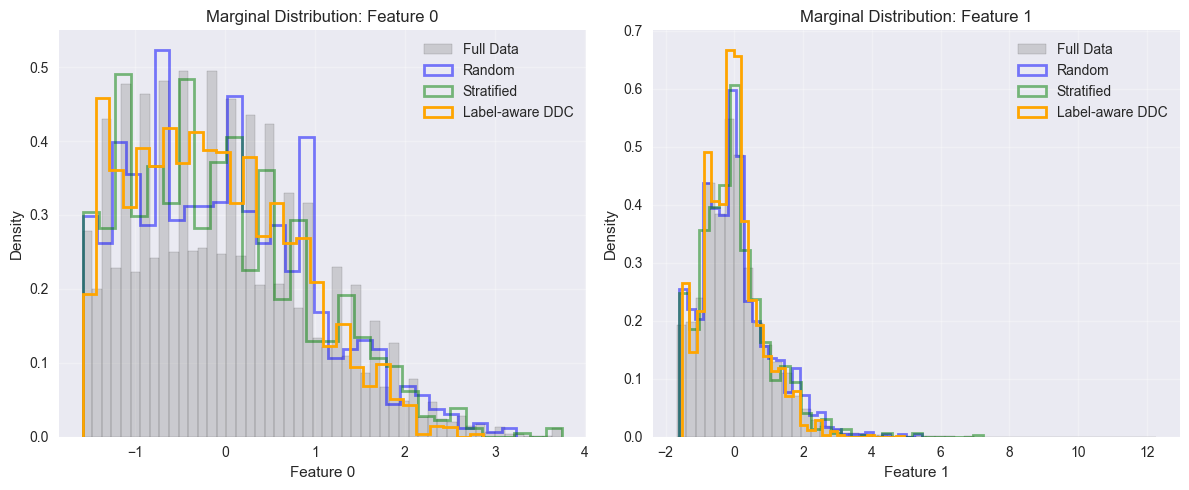

In [20]:
# Plot marginal distributions for a couple of features
n_features_to_plot = min(2, len(feature_indices))

fig, axes = plt.subplots(1, n_features_to_plot, figsize=(6 * n_features_to_plot, 5))
if n_features_to_plot == 1:
    axes = [axes]

for plot_idx, feat_idx in enumerate(feature_indices[:n_features_to_plot]):
    ax = axes[plot_idx]
    
    # Full training data (reference)
    ax.hist(X_train[:, feat_idx], bins=50, density=True, alpha=0.3, 
            label='Full Data', color='gray', edgecolor='black')
    
    # Random subset
    ax.hist(X_random[:, feat_idx], bins=30, density=True, alpha=0.5, 
            label='Random', color='blue', histtype='step', linewidth=2)
    
    # Stratified subset
    ax.hist(X_strat[:, feat_idx], bins=30, density=True, alpha=0.5, 
            label='Stratified', color='green', histtype='step', linewidth=2)
    
    # Label-aware DDC (weighted)
    ax.hist(S_labelaware[:, feat_idx], bins=30, weights=w_labelaware, density=True, 
            label='Label-aware DDC', color='orange', histtype='step', linewidth=2)
    
    ax.set_xlabel(f'Feature {feat_idx}')
    ax.set_ylabel('Density')
    ax.set_title(f'Marginal Distribution: Feature {feat_idx}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

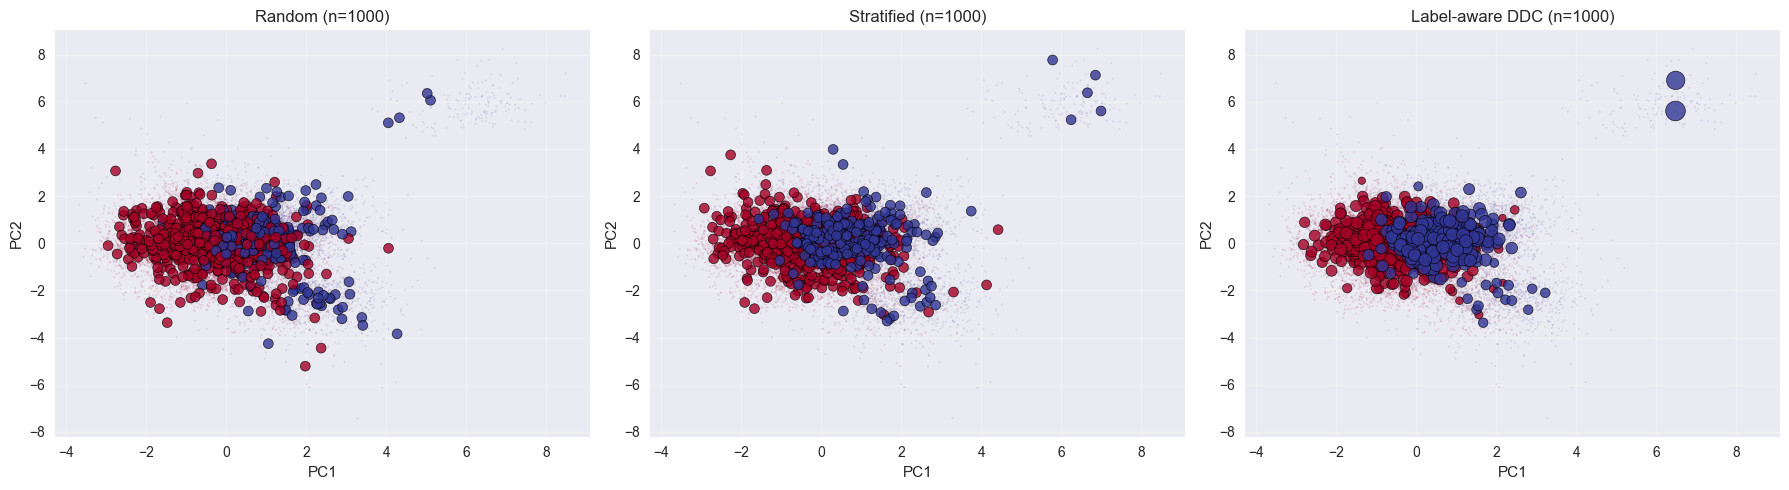

In [21]:
# 2D PCA projection to visualize spatial coverage
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca.fit_transform(X_train)

# Project subsets
X_random_2d = pca.transform(X_random)
X_strat_2d = pca.transform(X_strat)
S_labelaware_2d = pca.transform(S_labelaware)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods_2d = [
    ('Random', X_random_2d, y_random, None, 'blue'),
    ('Stratified', X_strat_2d, y_strat, None, 'green'),
    ('Label-aware DDC', S_labelaware_2d, y_labelaware, w_labelaware, 'orange'),
]

for ax, (method_name, subset_2d, subset_y, subset_w, color) in zip(axes, methods_2d):
    # Background: full data (low alpha)
    ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], 
              c=y_train, cmap='RdYlBu', alpha=0.1, s=1, label='Full Data')
    
    # Overlay: representatives
    if subset_w is not None:
        # Size proportional to weight
        sizes = 200 * (subset_w / subset_w.max())
    else:
        sizes = 50
    
    ax.scatter(subset_2d[:, 0], subset_2d[:, 1], 
              c=subset_y, cmap='RdYlBu', s=sizes, 
              edgecolors='black', linewidth=0.5, alpha=0.8, label=method_name)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'{method_name} (n={len(subset_2d)})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

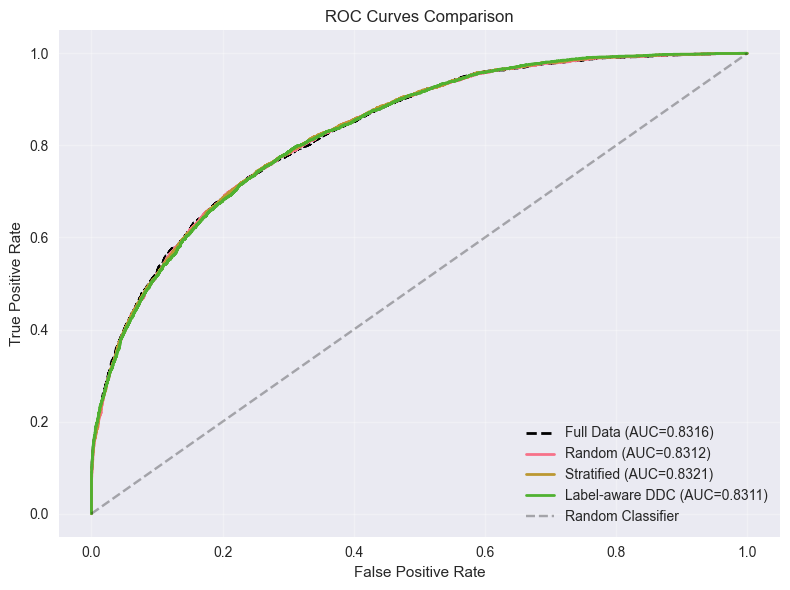

In [22]:
# ROC curves comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Full data baseline
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_proba_full)
ax.plot(fpr_full, tpr_full, label=f'Full Data (AUC={baseline_auc:.4f})', 
        linewidth=2, color='black', linestyle='--')

# Other methods
for method_name, y_pred_proba in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f'{method_name} (AUC={auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Discussion and Takeaways

### Key Observations

1. **Label-aware DDC preserves class balance**: By applying DDC separately within each class, we maintain label proportions while still benefiting from density–diversity selection **within each class**. This approach:
   - Preserves class proportions by design
   - Maintains distributional fidelity within each class
   - Typically performs closer to the full-data baseline than naive random sampling

2. **Distribution preservation matters**: Methods that better preserve marginal distributions (measured by Wasserstein-1 and KS statistics) tend to produce models that perform closer to the full-data baseline.

3. **Weights are essential**: DDC coresets are **weighted sets**, not just point sets. The weights allow us to approximate the full distribution from a small number of representatives.

4. **Parameter tuning matters**: For label-aware DDC, we adjust parameters (alpha, m_neighbors, refine_iters) based on class size to ensure good coverage and distribution preservation.

### When to Use Label-Aware DDC?

**Use Label-aware DDC when:**
- You're working on a **supervised learning** problem
- Label proportions matter (e.g., imbalanced classification)
- You want both distribution preservation AND label balance
- You need a small, interpretable subset for model prototyping
- You want to compress large datasets while maintaining class structure

**Use Random/Stratified sampling when:**
- You need a simple baseline for comparison
- You don't need distribution preservation
- Computational resources are extremely limited

### Conclusion

DDC coresets provide a principled way to compress large datasets while preserving distributional properties. For supervised learning tasks, **label-aware DDC** is the recommended approach as it combines the benefits of distribution preservation with label balance.

---

**Resources:**
- GitHub: https://github.com/crbazevedo/dd-coresets
- PyPI: https://pypi.org/project/dd-coresets/
- Documentation: See the main README for API details and more examples